## Import Libraries

In [23]:
>>> import nltk
>>> nltk.download('stopwords')
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,preprocessing
import torch
from torchtext import data
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import spacy
lang = spacy.load('en')
stemmer = PorterStemmer()
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler

stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
GPU Model    Tesla P100-PCIE-16GB


## Confusion Matrix Method

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Cleaning Data, Preprocessing

In [25]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=='Negative':
            y.values[i]=0.0
        else:
            y.values[i]=1.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

## Load Dataset and Process

In [26]:
with open("All_Tickers.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

# we will use the Neutrals in the end (All Neutrals)
# *************************************
Xnew_Neutrals=X[X['Target']=='Neutral']
Xnew_Neutrals=Xnew_Neutrals.sort_values("Date")
Xnew_Neutrals.drop_duplicates(inplace=True)
Xnew_Neutrals.index = range(len(Xnew_Neutrals))
Xnew_Neutrals['Article']=clean_data(Xnew_Neutrals['Article'])
Xnew_Neutrals['Target']=target_arrange(Xnew_Neutrals['Target'])
Xnew_Neutrals=Xnew_Neutrals.drop('Date',1)
# *******************************************

indexNames = X[X['Target'] == 'Neutral'].index
 
# Delete these row indexes from dataFrame
X.drop(indexNames , inplace=True)


X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")

X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

print("Negative Examples : ",(X['Target']==0).sum())
print("Positive Examples : ",(X['Target']==1).sum())


Number of Examples :  32853 

Number of Examples after removing duplicates:  32522 

Number of words before cleaning :  1097156
Number of words after cleaning :  716118

******************

Negative Examples :  16256
Positive Examples :  16266


## Stemming

In [27]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])
print(X['Article'])
Xv = X['Article'].to_frame()


# Stemming for Neutrals
#**********************************************************************************************************
Xnew_Neutrals['Article']= Xnew_Neutrals['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(Xnew_Neutrals['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    Xnew_Neutrals['Article'][i] = ' '.join(Xnew_Neutrals['Article'][i])
Xnew_Neutrals['Article'] = Xnew_Neutrals['Article'].to_frame()
Xnew_Neutrals.to_csv (r'All_Neutrals.csv', index = False, header=True)
#*************************************************************************************************************

0        actual econom impact coronaviru may wors data ...
1        futur tumbl start second quarter coronaviru cr...
2        compani cut job worst coronaviru shutdown hit ...
3        china economi may grow year happen year china ...
4        adp privat compani cut employe period march cn...
                               ...                        
32517    china changan ford sale grow year compani offi...
32518    look dividend time hold slvo look dividend tim...
32519    macroview astonish lack valu valu macroview as...
32520    septemb selloff healthi correct start new bear...
32521    china gac bmw expect china sale grow year chin...
Name: Article, Length: 32522, dtype: object


## Oversampling and Csvs

In [28]:
X_train,X_test,y_train,y_test = train_test_split(Xv,X['Target'], test_size=0.3,stratify=X['Target'])
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.2,stratify=y_train)

ros = RandomOverSampler()
X_train,y_train = ros.fit_resample(X_train, y_train)

train1=pd.DataFrame(columns=['Article','Target'])
val = pd.DataFrame(columns=['Article','Target'])
test= pd.DataFrame(columns=['Article','Target'])

df = pd.DataFrame(data = X_train,columns=['Article'])
df1= pd.DataFrame(data = y_train,columns=['Target'])
train1['Article']=df['Article']
train1['Target']=df1['Target']
df = pd.DataFrame(data = X_test,columns=['Article'])
df1= pd.DataFrame(data = y_test,columns=['Target'])
test['Article']=df['Article']
test['Target']=df1['Target']
df = pd.DataFrame(data = X_val,columns=['Article'])
df1= pd.DataFrame(data = y_val,columns=['Target'])
val['Article']=df['Article']
val['Target']=df1['Target']

print("Negative Examples in Training after OverSampling: ",(train1['Target']==0).sum())
print("Positive Examples in Training after OverSampling: ",(train1['Target']==1).sum())

train1.to_csv (r'Train_General.csv', index = False, header=True)
test.to_csv (r'Test_General.csv', index = False, header=True)
val.to_csv (r'Val_General.csv', index = False, header=True)




Negative Examples in Training after OverSampling:  9109
Positive Examples in Training after OverSampling:  9109


## Build Vocabulary

In [29]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'Train_General.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'Test_General.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'Val_General.csv',format = 'csv',fields = fields,skip_header = True)

TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  


Size of TEXT vocabulary: 15309
Size of LABEL vocabulary: 2
[('stock', 10034), ('earn', 6383), ('report', 4406), ('market', 3665), ('compani', 2791), ('expect', 2288), ('coronaviru', 2226), ('share', 2220), ('investor', 2149), ('trade', 2056)]


## Accuracy, Loss and Optimizer Function

In [30]:
def find_accuracy(preds, y):
    real_values=torch.sigmoid(preds)
    temp = torch.round(real_values)
    valid = (temp == y).float() 
    accur = valid.sum() / len(valid)
    return accur,temp,y,real_values

def Loss_Optimizer (model,valueLR):
    criterion = nn.BCEWithLogitsLoss()
    #criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

## Training and Testing Functions 

In [31]:
def train(model,data,lr,optimizer,criterion):
        
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text = i.text   
        optimizer.zero_grad()
        pred = model(text).squeeze(1)    
        loss = criterion(pred, i.label)
        acc,_,_,_ = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    real_v_list = []
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text = i.text
            
            pred = model(text).squeeze(1)
           
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true,real_v = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
            real_v_list+=real_v.flatten().tolist()
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list,real_v_list

def process_test(model,numEpochs,data_tr,data_val,data_test,lr,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,_,_ ,_= test(model, data_val, criterion)
        
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list, real_v_list= test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=3)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
     
    return real_v_list

def process_test2(model,numEpochs,data_tr,data_val,data_test,lr,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
        
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,_,_,_ = test(model, data_val, criterion)
        
        if i==0:
            minloss=valid_loss
            torch.save(model.state_dict(), best_model)
        elif valid_loss < minloss:
            minloss = valid_loss
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list, real_v_list= test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=3)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
    return real_v_list

## RNN Models

In [32]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
       
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return out

class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
        
        rnn_out,hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return out

In [33]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 1
batch=256
dropout = 0.4

train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(15309, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
myGRU(
  (embedding): Embedding(15309, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


## LSTM results

Epoch :  5  Train Loss :  0.1530738473455939   Train Acc :  0.9371744791666666   Valid Loss :  0.3198396356569396  Val Acc :  0.8991047342618307
Epoch :  10  Train Loss :  0.06410052756675416   Train Acc :  0.9762369791666666   Valid Loss :  0.42640740672747296  Val Acc :  0.9064832064840529
Epoch :  15  Train Loss :  0.03916331573337731   Train Acc :  0.9847547743055556   Valid Loss :  0.44949306630425984  Val Acc :  0.9096401664945815
Epoch :  20  Train Loss :  0.024216304859793227   Train Acc :  0.9907769097222222   Valid Loss :  0.5884158578183916  Val Acc :  0.9074905415376028
Epoch :  25  Train Loss :  0.014798768729734648   Train Acc :  0.9948459201388888   Valid Loss :  0.5876810418234931  Val Acc :  0.9083974659442902
Epoch :  30  Train Loss :  0.014811415353000889   Train Acc :  0.9942491319444444   Valid Loss :  0.6491689582665762  Val Acc :  0.908555097050137

Time needed for Training :  1.1374582846959431

Loss in Testset :  0.6685438110278203   Accuracy in Testset :  0.90

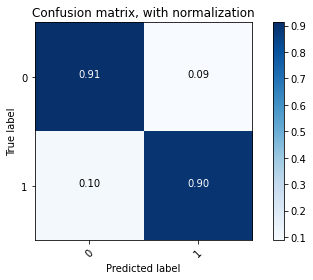

In [34]:
lstm_list=process_test(new_model2,30,train_it,val_it,test_it,0.001,"LSTM_Gen_PN.pt")

## GRU results

Epoch :  5  Train Loss :  0.17939713824954298   Train Acc :  0.9285430105196105   Valid Loss :  0.28853625141912037  Val Acc :  0.908831493722068
Epoch :  10  Train Loss :  0.080179031783094   Train Acc :  0.9694010416666666   Valid Loss :  0.35682416955629986  Val Acc :  0.9032279981507195
Epoch :  15  Train Loss :  0.047641375632439226   Train Acc :  0.9820421006944444   Valid Loss :  0.4550619406832589  Val Acc :  0.9078651865323385
Epoch :  20  Train Loss :  0.03314899470165579   Train Acc :  0.9878472222222222   Valid Loss :  0.49576035141944885  Val Acc :  0.9062273270554013
Epoch :  25  Train Loss :  0.021609087439072836   Train Acc :  0.9921875   Valid Loss :  0.5249520573351119  Val Acc :  0.9091078870826297
Epoch :  30  Train Loss :  0.01587102685071942   Train Acc :  0.9939236111111112   Valid Loss :  0.6471933126449585  Val Acc :  0.9054575198226504

Time needed for Training :  0.9748053034146626

Loss in Testset :  0.5963141864691025   Accuracy in Testset :  0.905517793618

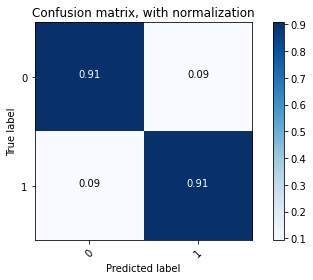

In [35]:
gru_list=process_test(new_model3,30,train_it,val_it,test_it,0.001,"GRU_Gen_PN.pt")

## Evaluate Semantic Neutrals as Positive-Negative

In [36]:
def sentence(model, s):
    model.eval()
    
    token = [tok.text for tok in lang.tokenizer(s)]
    index = [TEXT.vocab.stoi[t] for t in token]
    tensor = torch.LongTensor(index).to(device)
    tensor = tensor.unsqueeze(0)
    pred = torch.sigmoid(model(tensor))
    return pred.item()

In [37]:
# LSTM
Neutral_pd = pd.read_csv("new_Neutral_General.csv")
train_pd = pd.read_csv("Train_General.csv")


for index, row in Neutral_pd.iterrows():
    st=str(Neutral_pd['Article'][index])
    v=sentence(new_model2,st)
    if v>0.9:
      Neutral_pd['Target'][index]=1.0
    elif v<0.2:
      Neutral_pd['Target'][index]=0.0
    else:
      Neutral_pd['Target'][index]=2.0


#Delete these examples that are not classified as Positive or Negative
indexNames = Neutral_pd[Neutral_pd['Target'] == 2.0].index
 
# Delete these row indexes from dataFrame
Neutral_pd.drop(indexNames , inplace=True)

print("\nNumber of Neutrals that might be not Neutrals by LSTM : ",len(Neutral_pd))

# GRU
Neutral_pd2 = pd.read_csv("new_Neutral_General.csv")
for index, row in Neutral_pd2.iterrows():
    v=sentence(new_model3,str(Neutral_pd2['Article'][index]))
    if v>0.9:
      Neutral_pd2['Target'][index]=1.0
    elif v<0.2:
      Neutral_pd2['Target'][index]=0.0
    else:
      Neutral_pd2['Target'][index]=2.0

#Delete these examples that are not classified as Positive or Negative
indexNames = Neutral_pd2[Neutral_pd2['Target'] == 2.0].index
 
# Delete these row indexes from dataFrame
Neutral_pd2.drop(indexNames , inplace=True)

print("\nNumber of Neutrals that might be not Neutrals by GRU : ",len(Neutral_pd2))

Neutral_pd=Neutral_pd.merge(Neutral_pd2)

print("\nNumber of Neutrals that might be not Neutrals that agree LSTM and GRU : ",len(Neutral_pd))



Number of Neutrals that might be not Neutrals by LSTM :  2127

Number of Neutrals that might be not Neutrals by GRU :  2087

Number of Neutrals that might be not Neutrals that agree LSTM and GRU :  1808


In [38]:
count1=(Neutral_pd['Target']==0).sum()
count2=(Neutral_pd['Target']==1).sum()

if count2>count1:
  count3=count2//count1-1
  count4=count2%count1
  Xnew=Neutral_pd[Neutral_pd['Target']==0]
else:
  count3=count1//count2-1
  count4=count1%count2
  Xnew=Neutral_pd[Neutral_pd['Target']==1]

for i in range(count3):
  Neutral_pd = pd.concat([Neutral_pd,Xnew], ignore_index=True)

Xnew=Xnew.head(count4)

Neutral_pd = pd.concat([Neutral_pd,Xnew], ignore_index=True)
Neutral_pd = pd.concat([train_pd,Neutral_pd], ignore_index=True)
print("Negative Examples in Training after OverSampling: ",(Neutral_pd ['Target']==0).sum())
print("Positive Examples in Training after OverSampling: ",(Neutral_pd ['Target']==1).sum())
Neutral_pd = Neutral_pd.sample(frac=1).reset_index(drop=True)

Neutral_pd.to_csv (r'General_train_with_Neutrals.csv', index = False, header=True)

Negative Examples in Training after OverSampling:  10032
Positive Examples in Training after OverSampling:  10032


## Retrain Models with new examples from Semantic Neutrals

In [39]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'General_train_with_Neutrals.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'Test_General.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'Val_General.csv',format = 'csv',fields = fields,skip_header = True)

TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 1
batch=256
dropout = 0.4

train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)



new_model4 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model4.to(torch.device(device))
new_model5 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model5.to(torch.device(device))


myGRU(
  (embedding): Embedding(15963, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

## LSTM results after learning "Neutrals"

Epoch :  5  Train Loss :  0.1473660087566587   Train Acc :  0.940565664556962   Valid Loss :  0.30259333550930023  Val Acc :  0.89861132701238
Epoch :  10  Train Loss :  0.06727205697871462   Train Acc :  0.974947257886959   Valid Loss :  0.4915990498330858  Val Acc :  0.9005255831612481
Epoch :  15  Train Loss :  0.03473952064243487   Train Acc :  0.9875395569620253   Valid Loss :  0.5850945628351636  Val Acc :  0.9022023114893172
Epoch :  20  Train Loss :  0.023218474604330862   Train Acc :  0.9919402689873418   Valid Loss :  0.5806334349844191  Val Acc :  0.9057339164945815
Epoch :  25  Train Loss :  0.017915300591671957   Train Acc :  0.9939016352725935   Valid Loss :  0.6679018172952864  Val Acc :  0.902814484304852
Epoch :  30  Train Loss :  0.016966045144473828   Train Acc :  0.9942642405063291   Valid Loss :  0.6400822103023529  Val Acc :  0.9072530137168037

Time needed for Training :  1.2421727299690246

Loss in Testset :  0.6897919873396555   Accuracy in Testset :  0.9066022

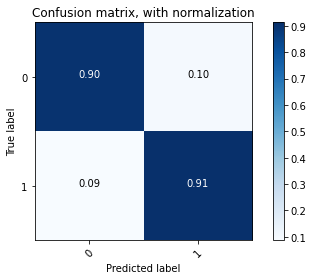

In [40]:
lstm_list2=process_test(new_model4,30,train_it,val_it,test_it,0.001,"LSTM_Gen_PN2.pt")

## GRU results after learning "Neutrals"

Epoch :  5  Train Loss :  0.1642461413446861   Train Acc :  0.9367912713485428   Valid Loss :  0.28324681520462036  Val Acc :  0.9020651943153806
Epoch :  10  Train Loss :  0.07303440936286992   Train Acc :  0.971733254722402   Valid Loss :  0.41050425585773254  Val Acc :  0.898908234304852
Epoch :  15  Train Loss :  0.040826770913185956   Train Acc :  0.9848694620253164   Valid Loss :  0.4696064194043477  Val Acc :  0.9064054720931582
Epoch :  20  Train Loss :  0.02665629814072406   Train Acc :  0.9900283496591109   Valid Loss :  0.5251888367864821  Val Acc :  0.9138433270984225
Epoch :  25  Train Loss :  0.022621822964895188   Train Acc :  0.9923852848101266   Valid Loss :  0.5222438226143519  Val Acc :  0.9113579226864709
Epoch :  30  Train Loss :  0.018650028150222157   Train Acc :  0.9932917990261996   Valid Loss :  0.5586287478605906  Val Acc :  0.9116731882095337

Time needed for Training :  1.0581895550092062

Loss in Testset :  0.5599816777767279   Accuracy in Testset :  0.904

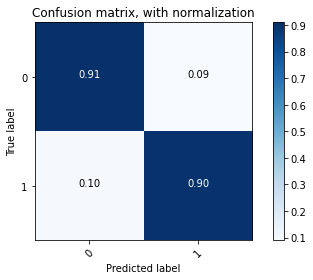

In [41]:
gru_list2=process_test(new_model5,30,train_it,val_it,test_it,0.001,"GRU_Gen_PN2.pt")